<a href="https://colab.research.google.com/github/FatimeNazliAs/Image-Segmentation-with-Oxford-IIIT-Pet-Dataset/blob/main/oxford_image_set_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
latest_folder_name="/content/drive/MyDrive/Shared/binamod_colab/petModel"


In [ ]:
from google.colab import files
import os
uploaded = files.upload()
dst ='image.jpg' 
os.rename(list(uploaded.keys())[0], dst)

Saving Abyssinian_9.jpg to Abyssinian_9.jpg


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import cv2
from glob import glob
from PIL import Image
import random

In [ ]:

def double_conv_block(x,n_filters):
  x=layers.Conv2D(n_filters,3,padding="same",activation="relu",kernel_initializer="he_normal")(x)
  x=layers.Conv2D(n_filters,3,padding="same",activation="relu",kernel_initializer="he_normal")(x)
  
  return x
  

def downsample_block(x,n_filters):
    f=double_conv_block(x,n_filters)
    p=layers.MaxPool2D(2)(f)
    p=layers.Dropout(0.3)(p)
    return f,p


def upsample_block(x,conv_features,n_filters):
  x=layers.Conv2DTranspose(n_filters,3,2,padding="same")(x)
  x=layers.concatenate([x,conv_features])
  x=layers.Dropout(0.3)(x)
  x=double_conv_block(x,n_filters)
  return x

In [ ]:
def build_unet_model():
  inputs=layers.Input(shape=(128,128,3))
  # encoder: contracting path - downsample
  f1,p1=downsample_block(inputs,64)
  f2,p2=downsample_block(p1,128)
  f3,p3=downsample_block(p2,256)
  f4,p4=downsample_block(p3,512)

  

  bottleneck=double_conv_block(p4,1024)

  # decoder: expanding path - upsample
  u6=upsample_block(bottleneck,f4,512)
  u7=upsample_block(u6,f3,256)
  u8=upsample_block(u7,f2,128)
  u9=upsample_block(u8,f1,64)

  outputs=layers.Conv2D(3,1,padding="same",activation = "softmax")(u9)

  unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
  return unet_model




In [ ]:
unet_model = build_unet_model()
latest = tf.train.latest_checkpoint(latest_folder_name)
unet_model.load_weights(latest)

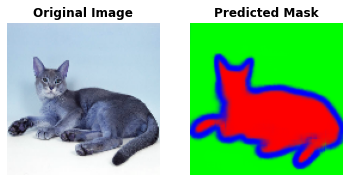

In [ ]:
image = cv2.imread("image.jpg" , cv2.IMREAD_COLOR)
image = cv2.resize(image, (128, 128))

plt.subplot(1,2,1)
plt.axis(False)
plt.title("Original Image", fontweight="bold")
plt.imshow(image)
plt.subplot(1,2,2)
plt.axis(False)
plt.title("Predicted Mask", fontweight="bold")
image = tf.cast(image, tf.float32) / 255.0
img = np.expand_dims(image,axis=0)
plt.imshow(unet_model.predict(img)[0,:,:,:]) 
plt.show() 